In [44]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt, yaml
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
# from torchvision.transforms import functional as F
import torch.nn.functional as F
import pandas as pd
from PIL import Image
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as Func
from datetime import datetime
from torchvision.io import read_image
import scipy.linalg
import time

In [45]:
def load_class_info(yaml_file):
    with open(yaml_file, 'r') as file:
            class_info = yaml.safe_load(file)
    return class_info['classes']

def label_transform(classes, labels, num_classes): #One-hot encoding
    class_to_index = {class_name: index for index, class_name in enumerate(classes)}
    target = np.zeros(num_classes, dtype=int)
    for label in labels:
        if label in class_to_index:
            index = class_to_index[label]
            target[index] = 1
    return target

def generate_ecc_codes(num_classes, code_length=None):
    hadamard_size = 1
    while hadamard_size < num_classes:
        hadamard_size *= 2

    # Generate the Hadamard matrix
    M = scipy.linalg.hadamard(hadamard_size).astype(np.float32)
    print("Scipy hadamard ", M.shape)
    
    # Replace the first column for every second row
    M[np.arange(0, hadamard_size, 2), 0] = -1
    print("Replaced ", M.shape)
    
    # Shuffle the rows and columns
    np.random.seed(12754)
    np.random.shuffle(M)
    idx = np.random.permutation(hadamard_size)
    
    # Select the required number of rows and columns
    M = M[0:num_classes, idx[0:code_length]]
    
    return M
    
def label_transform_ecc(classes, labels, codewords):
    class_to_index = {class_name: index for index, class_name in enumerate(classes)}
    if not isinstance(codewords, (list, np.ndarray)):
        raise ValueError("codewords should be a list or numpy array")
    
    if len(codewords) == 0 or not isinstance(codewords[0], (list, np.ndarray)):
        raise ValueError("codewords should be a non-empty list of lists or 2D numpy array")
    
    codeword_length = codewords.shape[0]
    target = np.zeros(codeword_length, dtype=int)
    for label in labels:
        if label in class_to_index:
            index = class_to_index[label]
            if index < len(codewords):
                target = codewords[index]
            else:
                print(f"Warning: Index {index} is out of range for codewords")
    
    return target

def ecc_encode(label, ecc_codes):
    class_index = label.index(1)  # Assuming label is initially one-hot
    return ecc_codes[class_index]
    
def transform(image, keypoints, one_hot_label, num_classes, image_size=(224, 224), fusion='concat'):
    transform_ops = transforms.Compose([
        transforms.Resize(image_size),
    ])
    image = transform_ops(image)
    keypoints = torch.tensor(keypoints).float()
    one_hot_label = torch.tensor(one_hot_label).float()
    one_hot_channel = one_hot_label.unsqueeze(1).unsqueeze(2).expand(len(one_hot_label), image_size[0], image_size[1])
    one_hot_channel = one_hot_channel.sum(dim=0, keepdim=True)
    
    input_combined = torch.cat((image, one_hot_channel), dim=0)

    if fusion == 'concat':
        input_combined = torch.cat((image, one_hot_channel), dim=0)

    elif fusion == 'add':
        if image.shape[0] == 3:
            padding = torch.zeros_like(image[0]).unsqueeze(0)
            padded_one_hot_channel = torch.cat([one_hot_channel, padding, padding], dim=0)
        input_combined = image + padded_one_hot_channel

    elif fusion == 'multiply':
        if image.shape[0] == 3:
            one_hot_channel = one_hot_channel.repeat(3, 1, 1)
        input_combined = image * one_hot_channel
        
    if fusion == 'concat':
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.0], std=[0.229, 0.224, 0.225, 1.0])
    else:
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    input_combined = normalize(input_combined)
    
    return input_combined, keypoints

def normal_transforms(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_transform = transform(image)
    return image_transform
    
def denormalize_image(image):
    denormalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    image = denormalize(image)
    image = torch.clamp(image, 0, 1)
    return image

def visualize_keypoints(image, keypoints):
    image = denormalize_image(image)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=10, marker='.', c='r')
    plt.show()

In [46]:
class CustomDataLoaderOneHot(Dataset):
    def __init__(self, dataset_folder, class_info_file, transform=None, label_transform=None, fusion_type='concat'):
        self.dataset_folder = dataset_folder
        self.transform = transform
        self.label_transform = label_transform
        self.imgs_files = self.load_data(dataset_folder)
        self.class_names = load_class_info(class_info_file)
        self.num_classes = len(self.class_names)
        self.fusion_type = fusion_type

    def load_data(self, dataset_folder):
        images_path = os.path.join(self.dataset_folder,"images/")
        annotations_path = os.path.join(self.dataset_folder,"annotations/")
        j_data = []
        for file in os.listdir(images_path):
            if file.endswith(".jpg"):
                json_path = os.path.join(annotations_path, file.split('.')[0] + '.json')
                with open(json_path) as f:
                    json_load = json.load(f)
                    for item in json_load['shapes']:
                        points = [value for row in item['points'] for value in row]
                        j_data.append({'image':  os.path.join(images_path,file),
                                     'label': item['label'],
                                     'points':points })
        json_data = pd.DataFrame(j_data)
        return json_data

    def get_keypoint(self, bboxes):
        centers = []
        for bbox in bboxes:
            center_x = (bbox[0] + bbox[2]) / 2
            center_y = (bbox[1] + bbox[3]) / 2
            centers.append((center_x, center_y))
        return centers
    
    def __len__(self):
        return len(self.imgs_files)

    def __getitem__(self, idx):
        target = {}
        img_path, label, bboxes_original = self.imgs_files.iloc[idx]
        label = [label]
        bboxes_original = [bboxes_original]
        keypoint_original = self.get_keypoint(bboxes_original)
        img_original = read_image(img_path).float() / 255.0

        if self.transform:
            label_transform = self.label_transform(self.class_names,label, self.num_classes)
            img, target['keypoints'] = self.transform(img_original, keypoint_original, label_transform, self.num_classes, fusion=self.fusion_type)
            target['labels'] = torch.as_tensor(label_transform, dtype=torch.int64)
        else:
            # img, bboxes = img_original, bboxes_original
            img, target['keypoints'] = img_original, keypoint_original
            target['labels'] = label

        return img, target, img_original

In [47]:
class CustomDataLoaderECC(Dataset):
    def __init__(self, dataset_folder, class_info_file, transform=None, label_transform=None, codeWords=None, fusion_type='concat'):
        self.dataset_folder = dataset_folder
        self.transform = transform
        self.label_transform = label_transform
        self.imgs_files = self.load_data(dataset_folder)
        self.class_names = load_class_info(class_info_file)
        self.num_classes = len(self.class_names)
        self.codeWords = codeWords
        
        self.fusion_type = fusion_type

    def load_data(self, dataset_folder):
        images_path = os.path.join(self.dataset_folder,"images/")
        annotations_path = os.path.join(self.dataset_folder,"annotations/")
        j_data = []
        for file in os.listdir(images_path):
            if file.endswith(".jpg"):
                json_path = os.path.join(annotations_path, file.split('.')[0] + '.json')
                with open(json_path) as f:
                    json_load = json.load(f)
                    for item in json_load['shapes']:
                        points = [value for row in item['points'] for value in row]
                        j_data.append({'image':  os.path.join(images_path,file),
                                     'label': item['label'],
                                     'points':points })
        json_data = pd.DataFrame(j_data)
        return json_data

    def get_keypoint(self, bboxes):
        centers = []
        for bbox in bboxes:
            center_x = (bbox[0] + bbox[2]) / 2
            center_y = (bbox[1] + bbox[3]) / 2
            centers.append((center_x, center_y))
        return centers
    
    def __len__(self):
        return len(self.imgs_files)

    def __getitem__(self, idx):
        target = {}
        img_path, label, bboxes_original = self.imgs_files.iloc[idx]
        label = [label]
        bboxes_original = [bboxes_original]
        keypoint_original = self.get_keypoint(bboxes_original)
        img_original = read_image(img_path).float() / 255.0

        if self.transform:
            label_transform = self.label_transform(self.class_names,label, self.codeWords)
            img, target['keypoints'] = self.transform(img_original, keypoint_original, label_transform, self.num_classes, fusion=self.fusion_type)
            target['labels'] = torch.as_tensor(label_transform, dtype=torch.int64)
        else:
            # img, bboxes = img_original, bboxes_original
            img, target['keypoints'] = img_original, keypoint_original
            target['labels'] = label

        return img, target, img_original

In [48]:
class NormalDataLoader(Dataset):
    def __init__(self, dataset_folder, class_info_file, transform=None, demo=False):
        self.dataset_folder = dataset_folder
        self.transform = transform
        # self.label_transform = label_transform
        self.demo = demo
        self.imgs_files = self.load_data(dataset_folder)
        self.class_names = load_class_info(class_info_file)
        self.num_classes = len(self.class_names)
        # self.normalize_keypoints = normalize_keypoints
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.class_names)}
        print(self.class_to_idx)

    def load_data(self, dataset_folder):
        images_path = os.path.join(self.dataset_folder,"images/")
        annotations_path = os.path.join(self.dataset_folder,"annotations/")
        j_data = []
        for file in os.listdir(images_path):
            if file.endswith(".jpg"):
                json_path = os.path.join(annotations_path, file.split('.')[0] + '.json')
                with open(json_path) as f:
                    json_load = json.load(f)
                    for item in json_load['shapes']:
                        points = [value for row in item['points'] for value in row]
                        j_data.append({'image':  os.path.join(images_path,file),
                                     'label': item['label'],
                                     'points':points })
        json_data = pd.DataFrame(j_data)
        return json_data

    def get_keypoint(self, bboxes):
        centers = []
        for bbox in bboxes:
            center_x = (bbox[0] + bbox[2]) / 2
            center_y = (bbox[1] + bbox[3]) / 2
            centers.append((center_x, center_y))
        return centers
    
    def __len__(self):
        return len(self.imgs_files)

    def __getitem__(self, idx):
        target = {}
        img_path, label, bboxes_original = self.imgs_files.iloc[idx]
        bboxes_original = [bboxes_original]
        target['labels'] = torch.tensor(self.class_to_idx[label], dtype=torch.int32)
        target['keypoints'] = torch.tensor(self.get_keypoint(bboxes_original), dtype=torch.float32)
        img_original = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img_original)

        return img, target, img_original

In [49]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [50]:
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=20, num_keypoints=1, num_channels=4): 
        super(CustomResNet18, self).__init__()
        
        self.num_keypoints = num_keypoints
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.fc_cls = nn.Linear(self.resnet18.fc.in_features, num_classes)
        self.fc_kpts = nn.Linear(self.resnet18.fc.in_features, self.num_keypoints * 2)
        self.resnet18.fc = nn.Identity()
        
    def forward(self, x):
        features = self.resnet18(x)
        class_outputs = self.fc_cls(features)
        keypoint_outputs = self.fc_kpts(features)
        return class_outputs, keypoint_outputs.reshape(-1, self.num_keypoints, 2)


class CustomResNet50(nn.Module):
    def __init__(self, num_classes=20, num_keypoints=1, num_channels=4): 
        super(CustomResNet50, self).__init__()
        
        self.num_keypoints = num_keypoints
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.fc_cls = nn.Linear(self.resnet50.fc.in_features, num_classes)
        self.fc_kpts = nn.Linear(self.resnet50.fc.in_features, self.num_keypoints * 2)
        self.resnet50.fc = nn.Identity()
        
    def forward(self, x):
        features = self.resnet50(x)
        class_outputs = self.fc_cls(features)
        keypoint_outputs = self.fc_kpts(features)
        return class_outputs, keypoint_outputs.reshape(-1, self.num_keypoints, 2)


class ConditionalSSD(nn.Module):
    def __init__(self, num_classes, num_keypoints, num_channels=4):
        super(ConditionalSSD, self).__init__()
        self.num_classes = num_classes
        self.num_keypoints = num_keypoints
        self.backbone = models.mobilenet_v2(pretrained=True).features
        
        # Adjust the first layer to accept the specified number of input channels
        self.backbone[0] = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )
        
        self.feature_map_layers = [6, 13, -1]
        self.out_channels = [self._get_out_channels(self.backbone[i]) for i in self.feature_map_layers]
        
        # Classification heads
        self.classification_heads = nn.ModuleList([
            nn.Conv2d(in_channels=out_channel, out_channels=num_classes, kernel_size=3, padding=1)
            for out_channel in self.out_channels
        ])
        
        # Keypoint heads
        self.keypoint_heads = nn.ModuleList([
            nn.Conv2d(in_channels=out_channel, out_channels=num_keypoints * 2, kernel_size=1)
            for out_channel in self.out_channels
        ])
        
    def _get_out_channels(self, layer):
        if isinstance(layer, nn.Sequential):
            for sublayer in layer:
                if isinstance(sublayer, nn.Conv2d):
                    return sublayer.out_channels
        elif isinstance(layer, nn.Conv2d):
            return layer.out_channels
        elif isinstance(layer, models.mobilenetv2.InvertedResidual):
            for sublayer in layer.conv:
                if isinstance(sublayer, nn.Conv2d):
                    out_channels = sublayer.out_channels
            return out_channels
        raise ValueError("Unsupported layer type: {}".format(type(layer)))
        
    def forward(self, x):
        features = []
        for i, layer in enumerate(self.backbone):
            x = layer(x)
            if i in self.feature_map_layers:
                features.append(x)
                
        # Apply classification and keypoint heads to each feature map
        class_outputs = []
        keypoint_outputs = []
        for feature, cls_head, kpt_head in zip(features, self.classification_heads, self.keypoint_heads):
            class_out = cls_head(feature)
            class_out = F.adaptive_avg_pool2d(class_out, (1, 1)).squeeze(-1).squeeze(-1)  # Global average pooling
            class_outputs.append(class_out)
            
            kpt_out = F.adaptive_avg_pool2d(feature, (1, 1))  # Global average pooling
            kpt_out = kpt_head(kpt_out).squeeze(-1).squeeze(-1).unsqueeze(1)  # Apply keypoint head, squeeze, and unsqueeze
            keypoint_outputs.append(kpt_out)
        
        # Concatenate outputs from different feature maps
        class_outputs = torch.mean(torch.stack(class_outputs), dim=0)  # Average over feature maps
        keypoint_outputs = torch.mean(torch.stack(keypoint_outputs), dim=0)  # Average over feature maps
        
        return class_outputs, keypoint_outputs

In [51]:
def LaplaceNLLLoss(input_data, target, scale, eps=1e-06, reduction='mean'):
    device = input_data.device
    target = target.to(device)
    scale = scale.to(device)
    
    # loss = torch.log(2*scale) + torch.abs(input_data - target)/scale

    # Inputs and targets much have same shape
    input_data = input_data.view(input_data.size(0), -1)
    target = target.view(target.size(0), -1)
    if input_data.size() != target.size():
        raise ValueError("input and target must have same size")

    # Second dim of scale must match that of input or be equal to 1
    scale = scale.view(input_data.size(0), -1)
    if scale.size(1) != input_data.size(1) and scale.size(1) != 1:
        raise ValueError("scale is of incorrect size")

    # Check validity of reduction mode
    if reduction != 'none' and reduction != 'mean' and reduction != 'sum':
        raise ValueError(reduction + " is not valid")
        
    # Entries of var must be non-negative
    if torch.any(scale < 0):
        raise ValueError("scale has negative entry/entries")

    # Clamp for stability
    scale = scale.clone()
    with torch.no_grad():
        scale.clamp_(min=eps)

    # Calculate loss (without constant)
    loss = (torch.log(2*scale) + torch.abs(input_data - target) / scale).view(input_data.size(0), -1).sum(dim=1)


    # Apply reduction
    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        return loss

In [52]:
def train_model(device, model, criterion_cls, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=25):
    train_losses = []
    valid_losses = []
    key_train_losses = []
    key_valid_losses = []
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        total_kpt_loss = 0.0

        for images, targets, labels in train_loader:
            labels = torch.stack([target['labels'] for target in targets])
            images = torch.stack(images).to(device)
            ground_truth_keypoints = torch.stack([target['keypoints'].to(device) for target in targets])

            # labels_tensor = torch.stack(labels)
            class_indices = torch.argmax(labels, dim=1)
            # print('labels shape: ', labels.count)
            optimizer.zero_grad()
            # print(abc)

            class_outputs, keypoint_outputs = model(images)

            scale = torch.rand(keypoint_outputs.shape) + 1e-6
            loss_cls = criterion_cls(class_outputs, class_indices)
            # loss_kpt=None
            loss_kpt = LaplaceNLLLoss(keypoint_outputs, ground_truth_keypoints, scale)
                # loss_kpt = criterion_kpt(keypoint_outputs, ground_truth_keypoints)
            class_loss = loss_cls 
            kpt_loss = loss_kpt
            # total_loss = loss_cls + loss_kpt # Combine losses for backpropagation
            class_loss.backward(retain_graph=True)
            kpt_loss.backward()
            
            optimizer.step()
            total_train_loss += loss_cls.item()
            total_kpt_loss += loss_kpt.item()

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        avg_kpt_loss = total_kpt_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Train Keypoint Loss: {avg_kpt_loss}')

        model.eval()
        total_val_loss = 0.0
        total_val_kpt_loss = 0.0

        with torch.no_grad():
            for images, targets, labels in valid_loader:
                labels = [target['labels'].to(device) for target in targets]
                images = torch.stack(images).to(device)
                ground_truth_keypoints = torch.stack([target['keypoints'].to(device) for target in targets])

                labels_tensor = torch.stack(labels)
                class_indices = torch.argmax(labels_tensor, dim=1)

                class_outputs, keypoint_outputs = model(images)
                
                scale = torch.rand(keypoint_outputs.shape) + 1e-6
                loss_cls = criterion_cls(class_outputs, class_indices)
                loss_kpt = LaplaceNLLLoss(keypoint_outputs, ground_truth_keypoints, scale)
                    # loss_kpt = criterion_kpt(keypoint_outputs, ground_truth_keypoints)
                
                total_val_loss += loss_cls.item() 
                total_val_kpt_loss += loss_kpt.item()

        avg_val_loss = total_val_loss / len(valid_loader.dataset)
        avg_val_kpt_loss = total_val_kpt_loss / len(valid_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss}, Val Keypoint Loss: {avg_val_kpt_loss}')
        
        train_losses.append(avg_train_loss)
        valid_losses.append(avg_val_loss)
        key_train_losses.append(avg_kpt_loss)
        key_valid_losses.append(avg_val_kpt_loss)

    return model, train_losses, key_train_losses, valid_losses, key_valid_losses  # Optionally return the model

In [53]:
class AutomatedTrainScript(Dataset):
    def __init__(self, class_config_path, DATASET_FOLDER_TRAIN, train_path, val_path, epochs_train, fusion_types, codewords, 
                           model_type, encoding_type, custom_model, custom_dataloader, transform, label_transform=None):
        
        self.class_config_path = class_config_path
        self.DATASET_FOLDER_TRAIN = DATASET_FOLDER_TRAIN
        self.train_path = train_path
        self.val_path = val_path
        self.epochs_train = epochs_train
        self.fusion_types = fusion_types
        self.codewords = codewords
        print("codewords self: ", self.codewords)
        self.model_type = model_type #resnet18, resnet50
        self.encoding_type = encoding_type # ecc, onehot
        self.custom_model = custom_model
        self.custom_dataloader = custom_dataloader
        self.transform = transform
        self.label_transform = label_transform
    

    def run(self):
        for fusion in self.fusion_types:
            for epochs in self.epochs_train:
                # if (self.model_type=='resnet18' and fusion=='concat' and self.encoding_type=='ecc') or (self.model_type=='resnet18' and fusion!='multiply' and self.encoding_type=='onehot'):
                    
                start_time = time.time()
                train_dataset = None
                valid_dataset = None
                # model = None
                
                print('***************************'+self.model_type+'_____'+fusion+'_____'+str(epochs)+'____'+self.encoding_type+'*********************************')
                
                if self.encoding_type == 'ecc':
                    train_dataset = self.custom_dataloader(self.train_path, self.class_config_path, transform=self.transform, 
                                                           label_transform=self.label_transform, codeWords=self.codewords, fusion_type=fusion)
                    valid_dataset = self.custom_dataloader(self.val_path, self.class_config_path, transform=self.transform, 
                                                           label_transform=self.label_transform, codeWords=self.codewords, fusion_type=fusion)
                elif self.encoding_type == 'onehot':
                    train_dataset = self.custom_dataloader(self.train_path, self.class_config_path, transform=self.transform, 
                                                           label_transform=self.label_transform, fusion_type=fusion)
                    valid_dataset = self.custom_dataloader(self.val_path, self.class_config_path, transform=self.transform, 
                                                           label_transform=self.label_transform, fusion_type=fusion)
                elif self.encoding_type == 'normal':
                    train_dataset = self.custom_dataloader(self.train_path, self.class_config_path, transform=self.transform)
                    valid_dataset = self.custom_dataloader(self.val_path, self.class_config_path, transform=self.transform)
                    
                train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
                valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
        
                iterator = iter(valid_loader)
                combined_input, targets, img = next(iterator)
                image_number = 0
                print("concatenated input size = ", combined_input[image_number].shape)
                
                num_channels = combined_input[image_number].shape[0]
                num_classes = len(load_class_info(self.class_config_path))
                num_keypoints = 1
                
                device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                
                model = self.custom_model(num_classes=num_classes, num_keypoints=num_keypoints, num_channels=num_channels)
                model.to(device)
                
                criterion_cls = nn.CrossEntropyLoss()
                criterion_kpt = nn.MSELoss()
                # criterion_kpt = LaplaceNLLLoss
                optimizer = optim.Adam(model.parameters(), lr=0.001)
                
                trained_model, train_loss, key_train_loss, val_loss, key_val_loss = train_model(device, model, criterion_cls, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=epochs)

                if self.encoding_type=='ecc':
                    torch.save(model.state_dict(), './'+self.model_type+'/models/updated_models/laplace/error_correcting/'+self.model_type+'_conditional_'+fusion+'_'+str(epochs)+'_epochs_laplace_ecc.pth')
                elif self.encoding_type=='onehot':
                    torch.save(model.state_dict(), './'+self.model_type+'/models/updated_models/laplace/one_hot/'+self.model_type+'_conditional_'+fusion+'_'+str(epochs)+'_epochs_laplace_onehot.pth')
                    
                losses = [train_loss, val_loss, key_train_loss, key_val_loss]
                label_losses = ['Training Loss', 'Validation Loss', 'Keypoint Training Loss', 'Keypoint Validation Loss']
                plot_paths = ['train_losses', 'val_losses', 'kpt_train_losses', 'kpt_val_losses']
                
                for loss, label_loss, plot_path in zip(losses, label_losses, plot_paths):
                    path=None
                    if self.encoding_type=='ecc':
                        path = './'+self.model_type+'/plots/updated_plots/laplace/error_correcting/'+plot_path+'_'+self.model_type+'_conditional_'+fusion+'_'+str(epochs)+'_epochs_laplace_ecc.png'
                    elif self.encoding_type=='onehot':
                        path = './'+self.model_type+'/plots/updated_plots/laplace/one_hot/'+plot_path+'_'+self.model_type+'_conditional_'+fusion+'_'+str(epochs)+'_epochs_laplace_onehot.png'
                    plots_all(loss, epochs, label_loss, path)

                end_time = time.time()
                inference_time = (end_time - start_time) * 1000
                
                print('$$$$$$$$$$$$$$$$$$$$$$_%%%%%%%%%%%%%%%%%%%%%%%_&&&&&&&&&&&&&&&&&&&&&&&&&&&&&_#############################')
                print('Training time : ', inference_time)
                print('$$$$$$$$$$$$$$$$$$$$$$_%%%%%%%%%%%%%%%%%%%%%%%_&&&&&&&&&&&&&&&&&&&&&&&&&&&&&_#############################')
        
    

In [54]:
def plots_all(loss, epochs, label_loss, path):
    plt.figure(figsize=(10, 6))
    plt.plot(loss, label=label_loss)
    plt.title(label_loss+' Over'+str(epochs)+' Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(path)
    plt.show()


In [55]:
class_config_path = './../config/formated_class.yaml'
DATASET_FOLDER_TRAIN = './../../../RnD_datasets/robocup_dataset'
train_path = os.path.join(DATASET_FOLDER_TRAIN,"train/")
val_path = os.path.join(DATASET_FOLDER_TRAIN,"val/")

num_classes = len(load_class_info(class_config_path))
codewords = generate_ecc_codes(num_classes, 16)
# print("codewords size", codewords.shape)
# epochs_list = [1000]
encoding_types = ['ecc','onehot']
epochs_list = [100, 250]
fusion_types = ['concat','add','multiply']

Scipy hadamard  (32, 32)
Replaced  (32, 32)


In [56]:
script_resnet50_ecc = AutomatedTrainScript(class_config_path, DATASET_FOLDER_TRAIN, train_path, val_path, 
                                           epochs_list, fusion_types, codewords, 'resnet50', 'ecc', CustomResNet50, 
                                           CustomDataLoaderECC, transform, label_transform_ecc)
script_resnet50_ecc.run()

print('################################################################################################################################')
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('------------------------------------------------- RESNET 50 ERROR CORRECTING TRAINING COMPLETED --------------------------------')
# check_time()
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('################################################################################################################################')


script_resnet50_onehot = AutomatedTrainScript(class_config_path, DATASET_FOLDER_TRAIN, train_path, val_path, 
                                              epochs_list, fusion_types, codewords, 'resnet50', 'normal', CustomResNet50, 
                                              NormalDataLoader, normal_transforms)
script_resnet50_onehot.run()

print('################################################################################################################################')
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('------------------------------------------------- RESNET 50 ONE HOT TRAINING COMPLETED -----------------------------------------')
# check_time()
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('################################################################################################################################')


script_ssd_ecc = AutomatedTrainScript(class_config_path, DATASET_FOLDER_TRAIN, train_path, val_path, 
                                           epochs_list, fusion_types, codewords, 'ssd', 'ecc', ConditionalSSD, 
                                           CustomDataLoaderECC, transform, label_transform_ecc)
script_ssd_ecc.run()

print('################################################################################################################################')
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('------------------------------------------------- SSD ERROR CORRECTING TRAINING COMPLETED --------------------------------')
# check_time()
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('################################################################################################################################')


script_ssd_onehot = AutomatedTrainScript(class_config_path, DATASET_FOLDER_TRAIN, train_path, val_path, 
                                              epochs_list, fusion_types, codewords, 'ssd', 'onehot', ConditionalSSD, 
                                              CustomDataLoaderOneHot, transform, label_transform)
script_ssd_onehot.run()

print('################################################################################################################################')
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('------------------------------------------------- SSD ONE HOT TRAINING COMPLETED -----------------------------------------')
# check_time()
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('################################################################################################################################')


script_resnet18_ecc = AutomatedTrainScript(class_config_path, DATASET_FOLDER_TRAIN, train_path, val_path, 
                                           epochs_list, fusion_types, codewords, 'resnet18', 'ecc', CustomResNet18, 
                                           CustomDataLoaderECC, transform, label_transform_ecc)
script_resnet18_ecc.run()

print('################################################################################################################################')
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('------------------------------------------------- RESNET 18 ERROR CORRECTING TRAINING COMPLETED --------------------------------')
# check_time()
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('################################################################################################################################')


script_resnet18_onehot = AutomatedTrainScript(class_config_path, DATASET_FOLDER_TRAIN, train_path, val_path, 
                                              epochs_list, fusion_types, codewords, 'resnet18', 'onehot', CustomResNet18, 
                                              CustomDataLoaderOneHot, transform, label_transform)
script_resnet18_onehot.run()

print('################################################################################################################################')
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('------------------------------------------------- RESNET 18 ONE HOT TRAINING COMPLETED -----------------------------------------')
# check_time()
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('********************************************************************************************************************************')
print('################################################################################################################################')

################################################################################################################################
********************************************************************************************************************************
********************************************************************************************************************************
********************************************************************************************************************************
------------------------------------------------- RESNET 50 ERROR CORRECTING TRAINING COMPLETED --------------------------------
********************************************************************************************************************************
********************************************************************************************************************************
*************************************************************************************************

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

concatenated input size =  torch.Size([3, 224, 224])


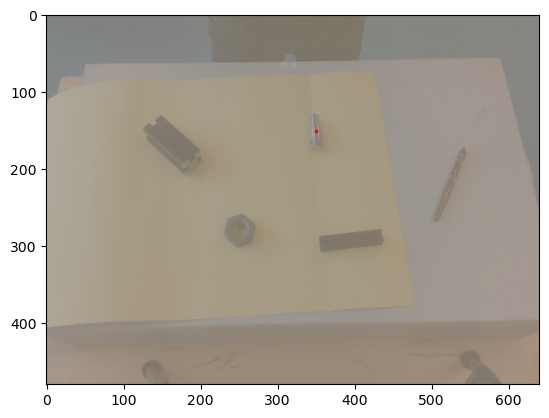

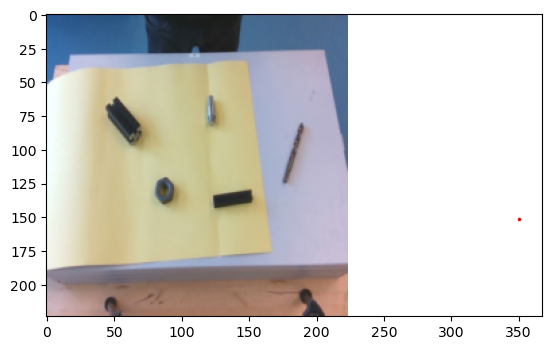

concatenated input size =  torch.Size([3, 224, 224])


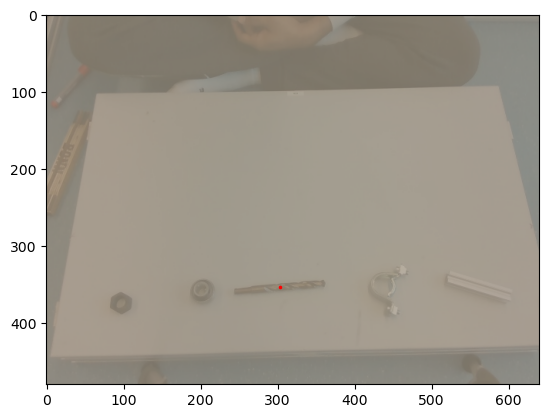

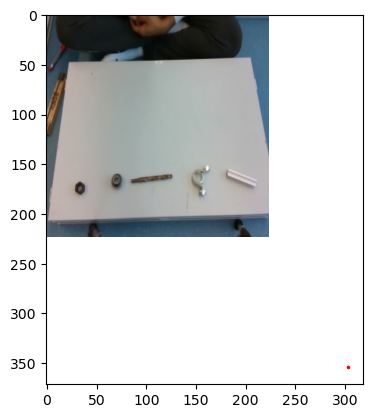

In [28]:
# def __init__(self, dataset_folder, class_info_file, transform=None, label_transform=None, fusion_type='concat'):

dataset_train = CustomDataLoaderOneHot(train_path, class_config_path, transform=transform, label_transform=label_transform, fusion_type='add')
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=collate_fn)

iterator = iter(dataloader_train)
combined_input, targets, img = next(iterator)
image_number = 0
print("concatenated input size = ", combined_input[image_number].shape)
visualize_keypoints(img[image_number], targets[image_number]['keypoints'])
visualize_keypoints(combined_input[image_number], targets[image_number]['keypoints'])





# dataset_train = CustomDataLoaderOneHot(train_path, class_config_path, transform=transform, label_transform=label_transform, fusion_type='concat')
# dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=collate_fn)

# iterator = iter(dataloader_train)
# combined_input, targets, img = next(iterator)
# image_number = 0
# print("concatenated input size = ", combined_input[image_number].shape)
# visualize_keypoints(img[image_number], targets[image_number]['keypoints'])
# visualize_keypoints(combined_input[image_number], targets[image_number]['keypoints'])





dataset_train = CustomDataLoaderOneHot(train_path, class_config_path, transform=transform, label_transform=label_transform, fusion_type='multiply')
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=collate_fn)

iterator = iter(dataloader_train)
combined_input, targets, img = next(iterator)
image_number = 0
print("concatenated input size = ", combined_input[image_number].shape)
visualize_keypoints(img[image_number], targets[image_number]['keypoints'])
visualize_keypoints(combined_input[image_number], targets[image_number]['keypoints'])